In [2]:
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

In [3]:
train_df = pd.read_parquet('train.parquet')
test_df = pd.read_parquet('test.parquet')

In [4]:
train_df

,id,dates,values,label
0,19114,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-1.86, 0.79, 1.4, 0.15, 0.0, -1.24, -1.46, 3....",0.0
1,22769,"[2016-05-01, 2016-06-01, 2016-07-01, 2016-08-0...","[-1.04, -3.48, 0.05, -0.13, -0.01, 0.03, 0.27,...",1.0
2,76935,"[2017-03-01, 2017-04-01, 2017-05-01, 2017-06-0...","[0.28, 0.63, 0.06, 0.96, -1.4, -0.3, 1.62, 1.1...",0.0
3,66297,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-0.33, 0.58, 1.1, -0.56, -0.95, -0.61, -0.7, ...",0.0
4,2191,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[1.31, 0.5, -0.54, 0.95, 0.65, 0.83, -1.55, -0...",0.0
...,...,...,...,...
79995,71474,"[2018-10-01, 2018-11-01, 2018-12-01, 2019-01-0...","[-0.15, -1.13, -0.87, 0.49, 0.87, 1.67, 1.91, ...",0.0
79996,36908,"[2016-07-01, 2016-08-01, 2016-09-01, 2016-10-0...","[-0.35, -1.31, 0.11, 1.46, 1.28, 1.12, 1.78, 1...",1.0
79997,63517,"[2016-03-01, 2016-04-01, 2016-05-01, 2016-06-0...","[-0.78, -2.27, -1.85, -0.67, -1.2, -2.02, 0.12...",0.0
79998,94731,"[2016-02-01, 2016-03-01, 2016-04-01, 2016-05-0...","[-2.29, -2.85, 0.92, -0.83, -1.75, -1.81, -2.2...",0.0


In [5]:
train_df['ts_start_date'] = train_df['dates'].apply(lambda ts_dates: ts_dates[0])

In [6]:
test_df['ts_start_date'] = test_df['dates'].apply(lambda ts_dates: ts_dates[0])

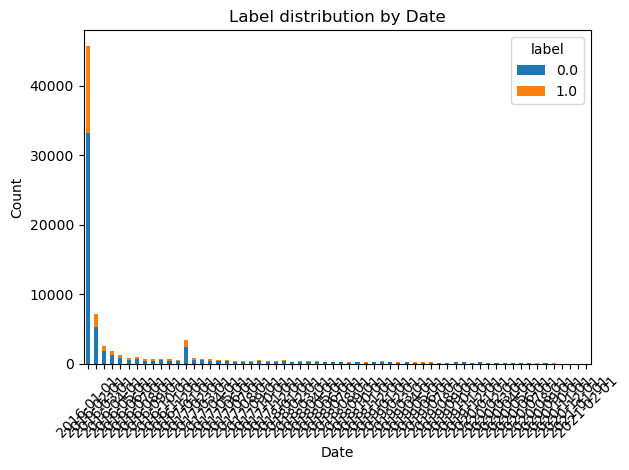

In [7]:
# Группируем данные по date и label, подсчитываем количество
grouped = train_df.groupby(['ts_start_date', 'label']).size().unstack(fill_value=0)

# Строим график
grouped.plot(kind='bar', stacked=True)

plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Label distribution by Date')
plt.xticks(rotation=45)
plt.tight_layout()  # Чтобы подогнать разметку
plt.show()

In [8]:
f_class = train_df[train_df['label'] == 0]
s_class = train_df[train_df['label'] == 1]

In [9]:
f_values = []
for i, row in f_class.iterrows():
    for i in row['values']:
        f_values.append(i)

In [10]:
s_values = []
for i, row in s_class.iterrows():
    for i in row['values']:
        s_values.append(i)

In [11]:
import collections

f_counter = collections.Counter(f_values)

s_counter = collections.Counter(s_values)

In [14]:
train_df

,id,dates,values,label,ts_start_date
0,19114,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-1.86, 0.79, 1.4, 0.15, 0.0, -1.24, -1.46, 3....",0.0,2016-01-01
1,22769,"[2016-05-01, 2016-06-01, 2016-07-01, 2016-08-0...","[-1.04, -3.48, 0.05, -0.13, -0.01, 0.03, 0.27,...",1.0,2016-05-01
2,76935,"[2017-03-01, 2017-04-01, 2017-05-01, 2017-06-0...","[0.28, 0.63, 0.06, 0.96, -1.4, -0.3, 1.62, 1.1...",0.0,2017-03-01
3,66297,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-0.33, 0.58, 1.1, -0.56, -0.95, -0.61, -0.7, ...",0.0,2016-01-01
4,2191,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[1.31, 0.5, -0.54, 0.95, 0.65, 0.83, -1.55, -0...",0.0,2016-01-01
...,...,...,...,...,...
79995,71474,"[2018-10-01, 2018-11-01, 2018-12-01, 2019-01-0...","[-0.15, -1.13, -0.87, 0.49, 0.87, 1.67, 1.91, ...",0.0,2018-10-01
79996,36908,"[2016-07-01, 2016-08-01, 2016-09-01, 2016-10-0...","[-0.35, -1.31, 0.11, 1.46, 1.28, 1.12, 1.78, 1...",1.0,2016-07-01
79997,63517,"[2016-03-01, 2016-04-01, 2016-05-01, 2016-06-0...","[-0.78, -2.27, -1.85, -0.67, -1.2, -2.02, 0.12...",0.0,2016-03-01
79998,94731,"[2016-02-01, 2016-03-01, 2016-04-01, 2016-05-0...","[-2.29, -2.85, 0.92, -0.83, -1.75, -1.81, -2.2...",0.0,2016-02-01


In [12]:
train_df[train_df['values']]['values'].apply(lambda x: len(x))

plt.scatter(x=train_df['values'].apply(lambda x: len(x)), y=train_df['label'])

TypeError: unhashable type: 'numpy.ndarray'

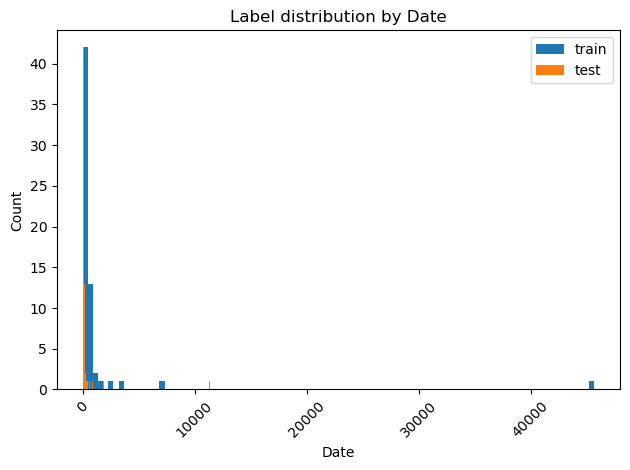

In [39]:
# Группируем данные по date и label, подсчитываем количество
grouped_train = train_df.groupby(['ts_start_date']).size()
grouped_test = test_df.groupby(['ts_start_date']).size()

# Строим график
grouped_train.plot(kind='hist', label="train", bins=100)
grouped_test.plot(kind='hist', label="test", bins=100)

plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Label distribution by Date')
plt.xticks(rotation=45)

plt.legend()
plt.tight_layout()  # Чтобы подогнать разметку
plt.show()

In [17]:
import numpy as np

In [18]:
def extract_fft_features(signal):
    """Extracts magnitude of FFT as features."""
    fft_values = np.fft.fft(signal)
    magnitudes = np.abs(fft_values)
    return magnitudes[:len(magnitudes)//2]  # Use only first half (positive frequencies)

In [19]:
train_df['frequencies'] = train_df['values'].apply(extract_fft_features)

In [20]:
test_df['frequencies'] = test_df['values'].apply(extract_fft_features)

<Axes: >

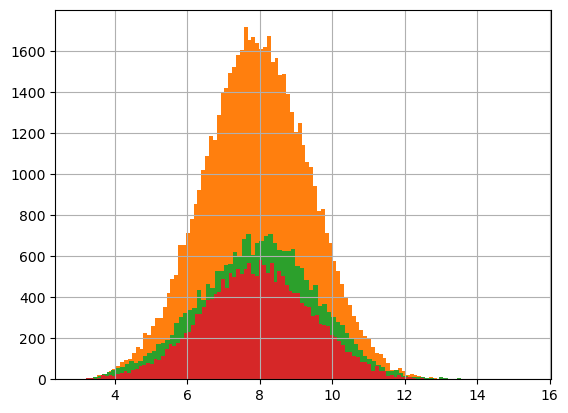

In [21]:
test_df['frequencies'].apply(lambda x: np.array(x).mean()).hist(bins=100)
train_df[train_df['label'] == 0]['frequencies'].apply(lambda x: np.array(x).mean()).hist(bins=100)
train_df[train_df['label'] == 1]['frequencies'].apply(lambda x: np.array(x).mean()).hist(bins=100)

test_df['frequencies'].apply(lambda x: np.array(x).mean()).hist(bins=100)


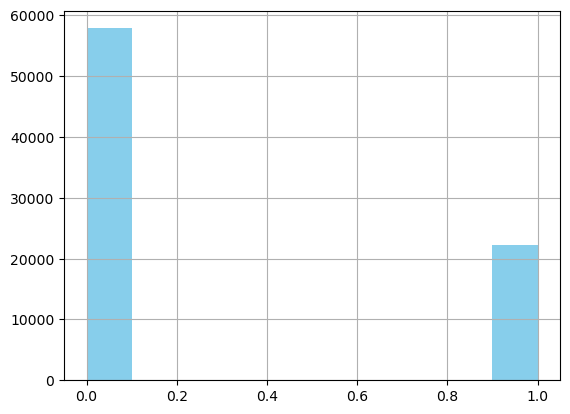

In [22]:
plt.hist(train_df['label'], color='skyblue')

plt.grid()
plt.show()

В тренировочном наборе данных есть дисбаланс классов. Учтём это при построении кросс-валидации.

### Частотное распределение временных рядов

Для начала перейдем 

In [23]:
train_df['mean_ts_value'] = train_df['values'].apply(lambda x: np.array(x).mean())

In [24]:
train_df['std_ts_value'] = train_df['values'].apply(lambda x: np.array(x).std())

In [25]:
train_df['max_ts_value'] = train_df['values'].apply(lambda x: np.array(x).max())
train_df['min_ts_value'] = train_df['values'].apply(lambda x: np.array(x).min())

In [42]:
train_df['std_mul_mean'] =  train_df['mean_ts_value'] / train_df['std_ts_value']

<Axes: >

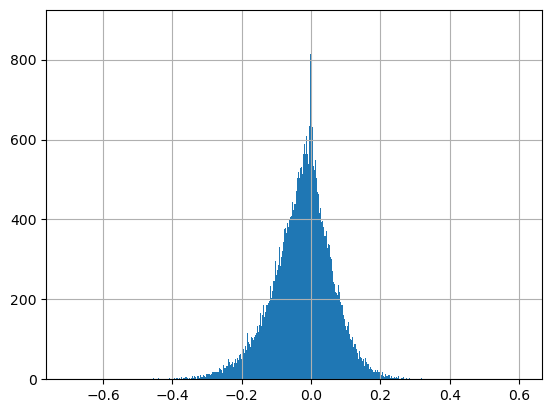

In [43]:
train_df['std_mul_mean'].hist(bins=1000)

In [44]:
train_df

,id,dates,values,label,ts_start_date,frequencies,mean_ts_value,std_ts_value,max_ts_value,min_ts_value,std_mul_mean,max_freq,min_freq
0,19114,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-1.86, 0.79, 1.4, 0.15, 0.0, -1.24, -1.46, 3....",0.0,2016-01-01,"[1.4700000000000015, 11.30893234913658, 4.4849...",0.023710,1.337272,3.49,-4.840000,0.017730,20.405218,0.836869
1,22769,"[2016-05-01, 2016-06-01, 2016-07-01, 2016-08-0...","[-1.04, -3.48, 0.05, -0.13, -0.01, 0.03, 0.27,...",1.0,2016-05-01,"[13.984957017678555, 19.890792462687223, 9.176...",-0.310777,1.556337,2.92,-3.534409,-0.199685,19.890792,3.326871
2,76935,"[2017-03-01, 2017-04-01, 2017-05-01, 2017-06-0...","[0.28, 0.63, 0.06, 0.96, -1.4, -0.3, 1.62, 1.1...",0.0,2017-03-01,"[2.210000000000001, 20.514391558737533, 5.3759...",-0.046042,1.065023,2.61,-1.950000,-0.043231,20.514392,1.068315
3,66297,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-0.33, 0.58, 1.1, -0.56, -0.95, -0.61, -0.7, ...",0.0,2016-01-01,"[6.24, 30.75772108580178, 4.1312753467152845, ...",-0.130000,1.158201,2.49,-2.220000,-0.112243,30.757721,0.320216
4,2191,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[1.31, 0.5, -0.54, 0.95, 0.65, 0.83, -1.55, -0...",0.0,2016-01-01,"[15.15, 5.319691984766741, 2.669083302096537, ...",-0.270536,1.270529,2.87,-2.500000,-0.212932,21.570369,0.406369
...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,71474,"[2018-10-01, 2018-11-01, 2018-12-01, 2019-01-0...","[-0.15, -1.13, -0.87, 0.49, 0.87, 1.67, 1.91, ...",0.0,2018-10-01,"[9.010000000000003, 9.352903249911247, 5.75793...",0.163818,1.303965,2.56,-3.640000,0.125631,16.522092,0.963164
79996,36908,"[2016-07-01, 2016-08-01, 2016-09-01, 2016-10-0...","[-0.35, -1.31, 0.11, 1.46, 1.28, 1.12, 1.78, 1...",1.0,2016-07-01,"[5.9654298836029405, 2.288811735954563, 8.0122...",-0.112555,1.216413,2.16,-2.590000,-0.092531,23.811466,2.132321
79997,63517,"[2016-03-01, 2016-04-01, 2016-05-01, 2016-06-0...","[-0.78, -2.27, -1.85, -0.67, -1.2, -2.02, 0.12...",0.0,2016-03-01,"[10.27, 25.38055443408125, 12.00595968191802, ...",-0.201373,1.182551,2.27,-2.890000,-0.170287,25.380554,1.445251
79998,94731,"[2016-02-01, 2016-03-01, 2016-04-01, 2016-05-0...","[-2.29, -2.85, 0.92, -0.83, -1.75, -1.81, -2.2...",0.0,2016-02-01,"[4.750000000000001, 12.969496110159241, 2.5794...",-0.075397,1.491254,3.11,-2.850000,-0.050559,31.562023,2.579450


In [45]:
train_df['max_freq'] = train_df['frequencies'].apply(lambda x: np.array(x).max())

<Axes: >

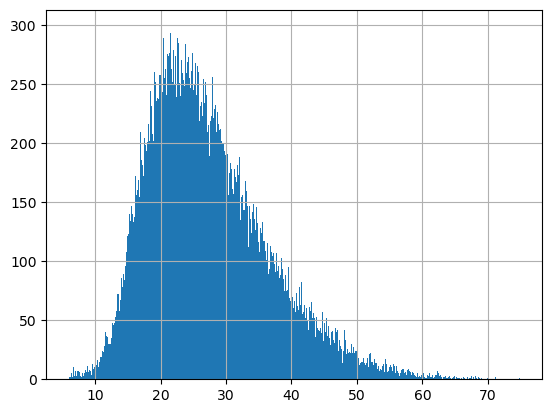

In [46]:
train_df['max_freq'].hist(bins=1000)

In [47]:
train_df['min_freq'] = train_df['frequencies'].apply(lambda x: np.array(x).min())



In [48]:
final_train_df = train_df[['mean_ts_value', 'std_ts_value','max_ts_value', 'min_ts_value', 'max_freq', 'min_freq', 'ts_start_date', 'std_mul_mean', 'label']].copy()
final_train_df['ts_start_date'] = final_train_df['ts_start_date'].astype(str)

#### Подбор гиперпараметров модели

In [49]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier

X = final_train_df.drop(['label'], axis=1)
y = final_train_df['label']

def objective(trial):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    params = {}

    roc_aucs = []
    for train_index, test_index in skf.split(X=X, y=y):

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        clf = CatBoostClassifier()
        clf.fit(X=X_train, 
                y=y_train, 
                eval_set=(X_test, y_test), 
                use_best_model=True,
                cat_features=['ts_start_date'],
                verbose=0)
        
        y_pred_prob = clf.predict_proba(X_test)
        roc_aucs.append(roc_auc_score(y_true=y_test, y_score=y_pred_prob[:, 1]))

    roc_aucs = np.array(roc_aucs)
    return roc_aucs.mean() - roc_aucs.std()

objective(None)

0.832410106659531

In [ ]:
import optuna

study = optuna.create_study()

In [50]:
X = final_train_df.drop(['label'], axis=1)
y = final_train_df['label']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=42)

In [51]:
clf = CatBoostClassifier()
clf.fit(X=X_train, 
                y=y_train, 
                eval_set=(X_test, y_test), 
                use_best_model=True,
                cat_features=['ts_start_date'],
                verbose=0)

In [52]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

y = y_test
pred = clf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = metrics.roc_curve(y, pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='Final estimator')

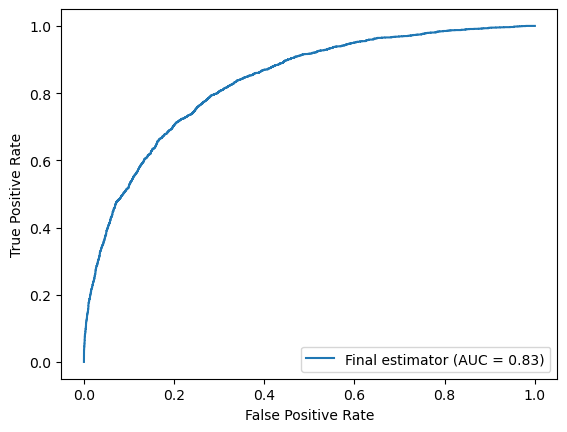

In [53]:
display.plot()
plt.show()

#### Формируем посылку

In [161]:
test_df['ts_start_date'] = test_df['ts_start_date'].astype(str)
test_df['mean_ts_value'] = test_df['values'].apply(lambda x: np.array(x).mean())
test_df['std_ts_value'] = test_df['values'].apply(lambda x: np.array(x).std())
test_df['max_ts_value'] = test_df['values'].apply(lambda x: np.array(x).max())
test_df['min_ts_value'] = test_df['values'].apply(lambda x: np.array(x).min())
test_df['max_freq'] = test_df['frequencies'].apply(lambda x: np.array(x).max())
test_df['min_freq'] = test_df['frequencies'].apply(lambda x: np.array(x).min())

ids = test_df['id']
final_test_X = test_df[['mean_ts_value', 'std_ts_value','max_ts_value', 'min_ts_value', 'max_freq', 'min_freq', 'ts_start_date']]

In [185]:
submission = pd.read_csv('sample_submission.csv')
submission['id'] = ids
submission['score'] = clf.predict_proba(final_test_X)[:, 1]
submission.to_csv('submission.csv', index=False)